In [58]:
import numpy as np
from blab.array import loadmat
from blab.array import marray_from_lists
from blab.itertools import true_meshgrid
from tqdm import tqdm
from numpy import ma
import mne
from scipy import stats
from matplotlib import pyplot as plt

In [41]:
cases = ['right_im1', 'right_im2', 'right_real', 'right_quasi']
bgr_case = 'right_real'

# res = loadmat('../data/TMS_EEG_RAW_D3_SHAM_PART1.mat')['res']
# res += loadmat('../data/TMS_EEG_RAW_D3_SHAM_PART2.mat')['res']
# res = data['res']
# res_bgr = data['res_bgr']

channels = np.array(res[0]['right_im1']['label']).flatten().tolist()

coi = ['FC5', 'FC1', 'FC2', 'FC6', 'C3', 'Cz', 'C4', 'CP5', 'CP1', 'CP2', 'CP6', 'T7', 'T8']
coi_mask = np.sum([np.array(channels) == i for i in coi], 0).astype(bool)
picks = np.r_[:len(channels)][coi_mask]

data_arrays = []
bgr_data_arrays_after = marray_from_lists([j[bgr_case]['trial'] if j is not None else None for j in res_bgr])
for case in tqdm(cases):
    temp = marray_from_lists([j[case]['trial'] if j is not None else None for j in res])[..., :9500:4][..., coi_mask, :]
    data_arrays.append(temp)

data_arrays = ma.stack(data_arrays)[:2] #cropped to only im1/im2

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:15<00:00,  3.80s/it]


In [59]:
data_arrays.shape

(2, 15, 20, 13, 2375)

In [61]:
montage = mne.channels.make_standard_montage('standard_1020')
info = mne.create_info(coi, 250, ch_types='eeg')
info.set_montage(montage)

sensor_adjacency, ch_names = mne.channels.find_ch_adjacency(
    info, 'eeg')

res_epochs = [mne.EpochsArray(i, info, verbose=False) for i in data_arrays.reshape(30, 20, 13, -1)]

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 13


In [62]:
freqs = np.r_[10.5:14.5:0.4]

# theta = (freqs < 8)* (freqs >= 4)
# alpha1 = (freqs < 11)* (freqs >= 8)
# alpha2 = (freqs < 14)* (freqs >= 11)
# beta = (freqs < 30) * (freqs >= 15)

def transform_func(x):
    temp = mne.time_frequency.tfr_morlet(x, freqs, freqs, use_fft=True, return_itc=False, n_jobs=10, average=False, verbose=False)
    temp = temp.crop(1, 9).apply_baseline((1, 5), mode='percent', verbose=False)
    temp = temp.average(dim='freqs')
    return temp

res_tfr = [transform_func(i) for i in tqdm(res_epochs)]
all_data = np.array([np.rollaxis(np.squeeze(i.data), 1, 3) for i in res_tfr]).reshape(1, 2, 15, 20, 2001, 13)[..., 1001:, :]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.78it/s]


In [63]:
np.save('../data/TMS_TIME-CH-TRIAL_DAY3_IM1-2_MOTOR-AREA_BCORR_POST.npy', all_data)

In [63]:
montage = mne.channels.make_standard_montage('standard_1020')
info = mne.create_info(np.array(channels)[coi_mask].tolist(), 250, ch_types='eeg')
info.set_montage(montage)


sensor_adjacency, ch_names = mne.channels.find_ch_adjacency(
    info, 'eeg')

results = []
for i in tqdm(all_data):
    for crit_mul in [0, 2, 5, 10]:
        alpha = 0.05/(2**int(crit_mul))
        thresh = stats.t.ppf(q=1 - alpha, df= 20 - 1)
        res = mne.stats.spatio_temporal_cluster_1samp_test(i[:, 1000:], n_permutations=2000,
                                                                 tail=0, n_jobs=15, out_type='mask',
                                                                 threshold=thresh,
                                                                 adjacency=sensor_adjacency, stat_fun=mne.stats.ttest_1samp_no_p,
                                                                 verbose=False)
        results.append(res)

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 13


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]C:\Users\NCT\AppData\Local\Temp/ipykernel_14796/2537142564.py:14: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  res = mne.stats.spatio_temporal_cluster_1samp_test(i[:, 1000:], n_permutations=2000,
 45%|█████████████████████████████████████▎                                             | 9/20 [05:18<06:39, 36.32s/it]C:\Users\NCT\AppData\Local\Temp/ipykernel_14796/2537142564.py:14: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  res = mne.stats.spatio_temporal_cluster_1samp_test(i[:, 1000:], n_permutations=2000,
 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [09:58<01:45, 35.30s/it]C:\Users\NCT\AppData\Local\Temp/ipykernel_14796/2537142564.py:14: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  res = mne.stats.spatio_tempor

In [39]:
time = res_im_data[0].times

In [66]:
npresults = np.array(results, dtype=object).reshape(2, 10, 4, -1)

[0.043 0.193]


C:\Users\NCT\AppData\Local\Temp/ipykernel_14796/549098088.py:6: RuntimeWarning: Mean of empty slice
  topo = np.nanmean((T_obs_filt).T[:,timefreq_mask], axis=-1)


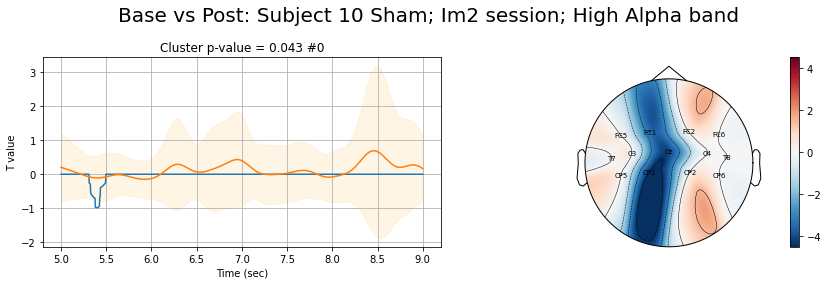

In [115]:
sub = 10
sub_real_ind = sub - 1
session = 2
session_ind = session - 1
session_names = ['Im1', 'Im2']
crit_mul_ind = 2

a = res_im_data[session_ind*10 + sub_real_ind].data
a = np.squeeze(a)
# a = np.swapaxes(a, 0, -1)
# a_std = np.squeeze(np.apply_over_axes(np.nanstd, a, [1, 2]))
a_std = a.std(0).mean(0)[..., 1000:]
# a = np.nanmean(a, -2)
a_mean = a.mean(0).mean(0)[..., 1000:]
mbrt_mean = 1.425

T_obs, clusters, cluster_p_values, _ = npresults[session_ind, sub_real_ind, crit_mul_ind]

inds = np.arange(len(cluster_p_values), dtype=int)[cluster_p_values < 0.05][::][:]
clusters_num = len(inds)
print(cluster_p_values)

fig, axes = plt.subplots(clusters_num, 2, figsize=(12, 4*clusters_num))

if clusters_num == 1:
    axes = [axes]
    
for temp_ind, (ax1, ax2) in enumerate(axes):
    ind = inds[temp_ind]
    ax1.plot(time[1000:], np.mean(T_obs*clusters[ind], axis=-1))
    ax1.plot(time[1000:], a_mean)
    ax1.fill_between(time[1000:], a_mean - a_std, a_mean + a_std, color='orange', alpha=0.1)
#     ax1.axvline(mbrt_mean + 5, color='red')
#     mbrt_std = 0.15
#     ax1.axvspan(mbrt_mean + 5 - mbrt_std, mbrt_mean + 5 + mbrt_std, color='red', alpha=0.1)
    ax1.set_ylabel('T value')
    ax1.set_xlabel('Time (sec)')
    ax1.grid()
    im, _ = plot_stat_topomap(T_obs, clusters[ind], info, axes=ax2)
    plt.colorbar(im, ax=ax2)
    ax1.set_title(f'Cluster p-value = {cluster_p_values[ind]} #{ind}')
fig.suptitle(f'Base vs Post: Subject {sub_real_ind + 1} Sham; {["Im1", "Im2"][session_ind]} session; High Alpha band', fontsize=20)
fig.tight_layout()

In [49]:
def plot_stat_topomap(T_obs, clus, info, axes=None, cl_ind=0):
    timefreq_mask = np.any(clus, axis=-1)
    nanmask = np.zeros(clus.shape)
    nanmask[~clus] = np.nan
    T_obs_filt = T_obs + nanmask
    topo = np.nanmean((T_obs_filt).T[:,timefreq_mask], axis=-1)
    topo[np.isnan(topo)] = 0
    return mne.viz.plot_topomap(topo, info, axes=axes, show=False, names=info.ch_names, show_names=True)

In [116]:
a = [8.7, 6.75, 6.0, 8.5, 9.0, 8.5, 6.5]
b = [6.5, 7.75, 7.23, 6.75, 6.5, 5.75, 6.2]

In [120]:
stats.ttest_ind(a, b, equal_var=False, permutations=10000)

Ttest_indResult(statistic=1.9582555223105924, pvalue=0.07459207459207459)

In [11]:
data = np.array(all_data).reshape(2, 10, 20, 2001, 13)
data = data[..., 1001:, :]

In [35]:
montage = mne.channels.make_standard_montage('standard_1020')
info = mne.create_info(np.array(channels)[coi_mask].tolist(), 250, ch_types='eeg')
info.set_montage(montage)


sensor_adjacency, ch_names = mne.channels.find_ch_adjacency(
    info, 'eeg')

test_func = lambda x, y: stats.ttest_rel(x, y, axis=0).statistic #lambda *x: stats.ttest_rel(x[0], x[1], axis=0).statistic

mul = 2
alpha = 0.05/(2**mul)
thresh = stats.t.ppf(q=1 - alpha, df= 10 - 1)
T_obs, clusters, cluster_p_values, _ = mne.stats.spatio_temporal_cluster_test(data.mean(2), n_permutations=2000,
                                                                                 tail=0, n_jobs=15, out_type='mask',
                                                                                 threshold=thresh,
                                                                                 adjacency=sensor_adjacency, stat_fun=test_func,
                                                                                 verbose=True)

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 13
stat_fun(H1): min=-2.341288 max=2.662579
Running initial clustering
Found 0 clusters


C:\Users\NCT\AppData\Local\Temp/ipykernel_5008/2062044715.py:14: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, _ = mne.stats.spatio_temporal_cluster_test(data.mean(2), n_permutations=2000,


In [33]:
cluster_p_values

array([0.9715, 0.3345, 0.6175, 0.8925])

In [37]:
data.shape

(2, 10, 20, 1000, 13)

In [38]:
a = np.nanmean(data, 2) # averaging over trials
a = np.swapaxes(a, 2, 3)
a = a.mean(2)

In [39]:
a.shape

(2, 10, 1000)

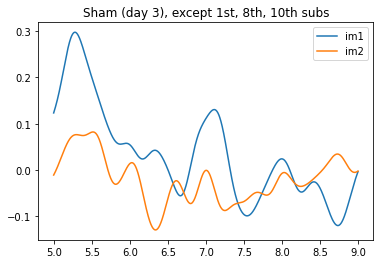

In [45]:
time = np.r_[1:9:0.004][1000:]
submask = np.r_[:10] > -1
submask[0] = False
submask[7] = False
submask[9] = False
plt.plot(time, a[0, submask].mean(0), label='im1')
plt.plot(time, a[1, submask].mean(0), label='im2')
plt.legend();
plt.title('Sham (day 3), except 1st, 8th, 10th subs');

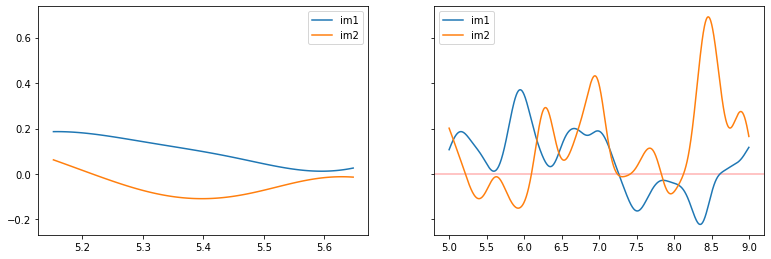

In [104]:
d3im1_mbrt = [np.nan, 6.58, 6.25, np.nan, 6.0, np.nan, 5.8, 5.9,    6.4,  7.5]
d3im2_mbrt = [6.1,    6.4,  7.5,  5.75,   6.0, 6.0,    5.8, np.nan, 6.15, 5.4]
sub = 9

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4.2), sharey=True)
center = 5.4
span = 0.25

temp = a[:, sub]

time_mask = (time < center + span) & (time > center - span)
time_masked = time[time_mask]
temp_masked = temp[..., time_mask]

ax1.plot(time_masked, temp_masked[0], label='im1')
ax1.plot(time_masked, temp_masked[1], label='im2')
ax1.legend();

ax2.axhline(color='red', alpha=0.3)
ax2.plot(time, temp[0], label='im1')
ax2.plot(time, temp[1], label='im2')
ax2.legend();


In [ ]:
df = np.stack([d3im1_mbrt, d3im2_mbrt])
dfmask = ~np.isnan